Notebook based on _Hands-On Graph Neural Networks Using Python_, by Maxime Labonne.

# Ch 6. Introducing Graph Convolutional Networks

In [1]:
import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

## 6.1 Introduction

We return to the node embedding calculation from chapter 5:

$$
H = \tilde{A}^T X W^T
$$

We noted that there is no normalization here, which means that nodes with a large number of neighbors will generally have higher embedding values. This makes it harder to compare embeddings.

We can fix this problem by normalizing the adjaceny matrix. We will use an approach called _asymmetric normalization_, in which we normalize each row to sum to 1 unit by dividing each row element by the node degree. The result is a _stochastic transition matrix_ &mdash; that is, it is the transition matrix of a Markov chain.

Let's work with a concrete example.

In [2]:
# Adjacency matrix
A = np.array([
    [0, 1, 1, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 1],
    [1, 0, 1, 0],
])
A

array([[0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0]])

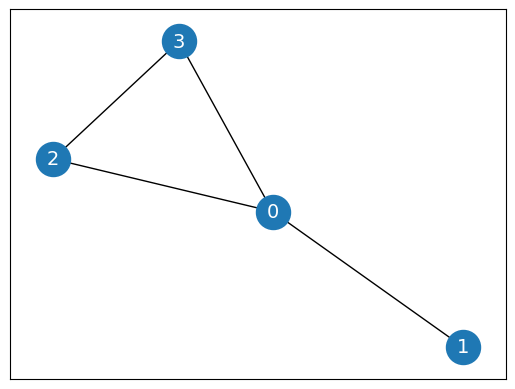

In [3]:
graph = nx.from_numpy_array(A)
nx.draw_networkx(
    graph,
    pos=nx.spring_layout(graph, seed=0),
    node_size=600,
    font_size=14,
    font_color='white')

In [4]:
nodes = list(graph.nodes())
degrees = np.array([graph.degree(n) for n in nodes])
D = np.diag(degrees)
D  # degree matrix

array([[3, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

In [5]:
# Add self-loops (see ch 5)
A_adj = A + np.identity(len(A))
D_adj = D + np.identity(len(D))
D_adj_inv = np.linalg.inv(D_adj)
D_adj_inv

array([[0.25      , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [6]:
D_adj_inv @ np.transpose(A_adj)

array([[0.25      , 0.25      , 0.25      , 0.25      ],
       [0.5       , 0.5       , 0.        , 0.        ],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333]])

This appears to be a good replacement for the unnormalized adjacency matrix, but Kipf and Welling (see [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)) discovered that features from nodes having lots of neighbors tend to spread easily. They propose a modification to the asymmetric normalization above, where they assign higher weights to nodes with fewer neighbors. Here is what they use:

$$
H = \tilde{D}^{-\frac{1}{2}} \tilde{A}^T \tilde{D}^{-\frac{1}{2}} X W^T
$$

## 6.2 GCN code 

In [7]:
# Simple accuracy measure -- not intended for production use.
# The NNs below use this for training.
def accuracy(y_pred, y_true):
    return torch.sum(y_pred == y_true) / len(y_true)

In [8]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
            train_loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                train_acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

## 6.2 GCN classification task

### 6.2.1 Cora dataset

In [9]:
# Citation network datasets
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html
# https://arxiv.org/abs/1603.08861
from torch_geometric.datasets import Planetoid

In [10]:
# Note that the Cora data has training, validation and test masks by default, so we
# don't have to set those explicitly here. (Below with the Facebook Page-Page data,
# we will have to do it ourselves.)
cora_ds = Planetoid(root=".", name="Cora")
cora_data = cora_ds[0]

In [11]:
cora_gcn = GCN(cora_ds.num_features, 16, cora_ds.num_classes)
print(cora_gcn)
cora_gcn.fit(cora_data, epochs=100)

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)
Epoch   0 | Train Loss: 1.95 | Train Acc: 12.14% | Val Loss: 1.95 | Val Acc: 9.20%
Epoch  20 | Train Loss: 0.11 | Train Acc: 100.00% | Val Loss: 0.76 | Val Acc: 76.60%
Epoch  40 | Train Loss: 0.01 | Train Acc: 100.00% | Val Loss: 0.74 | Val Acc: 76.60%
Epoch  60 | Train Loss: 0.01 | Train Acc: 100.00% | Val Loss: 0.72 | Val Acc: 77.40%
Epoch  80 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 77.20%
Epoch 100 | Train Loss: 0.02 | Train Acc: 100.00% | Val Loss: 0.71 | Val Acc: 76.80%


In [12]:
acc = cora_gcn.test(cora_data)
print(f'\nCora GCN test accuracy: {acc*100:.2f}%')


Cora GNN test accuracy: 80.70%


### 6.2.2 Facebook Page-Page dataset

In [13]:
from torch_geometric.datasets import FacebookPagePage

In [14]:
fb_ds = FacebookPagePage(root="./FacebookPagePage")
fb_data = fb_ds[0]

In [15]:
# We have to define these explicitly, because unlike the Cora data, the Facebook
# Page-Page data doesn't come with them.
fb_data.train_mask = range(18000)        # Training
fb_data.val_mask = range(18001, 20000)   # Validation
fb_data.test_mask = range(20001, 22470)  # Test

In [17]:
fb_gcn = GCN(fb_ds.num_features, 16, fb_ds.num_classes)
print(fb_gcn)
fb_gcn.fit(fb_data, epochs=100)

GCN(
  (gcn1): GCNConv(128, 16)
  (gcn2): GCNConv(16, 4)
)
Epoch   0 | Train Loss: 1.40 | Train Acc: 25.51% | Val Loss: 1.40 | Val Acc: 25.81%
Epoch  20 | Train Loss: 0.45 | Train Acc: 85.34% | Val Loss: 0.44 | Val Acc: 85.99%
Epoch  40 | Train Loss: 0.31 | Train Acc: 90.02% | Val Loss: 0.30 | Val Acc: 90.20%
Epoch  60 | Train Loss: 0.27 | Train Acc: 91.73% | Val Loss: 0.26 | Val Acc: 91.60%
Epoch  80 | Train Loss: 0.25 | Train Acc: 92.71% | Val Loss: 0.25 | Val Acc: 92.35%
Epoch 100 | Train Loss: 0.23 | Train Acc: 93.04% | Val Loss: 0.24 | Val Acc: 92.50%


In [18]:
acc = fb_gcn.test(fb_data)
print(f'\nFacebook Page-Page GCN test accuracy: {acc*100:.2f}%')


Facebook Page-Page GCN test accuracy: 92.14%


## 6.3 GCN prediction task

In [ ]:
# TODO

## 6.4 Further reading

- [Spectral Networks and Locally Connected Networks on Graphs](https://arxiv.org/abs/1312.6203)
- [Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](https://arxiv.org/abs/1606.09375)
- [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)